<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Object_Detection/RetinaNet(2017).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 코드 출처
- https://github.com/kuangliu/pytorch-retinanet

In [151]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dataset 불러오기

In [7]:
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [97]:

# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [101]:
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())

        targets = []
        # get class, bounding box coordinates
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = classes.index(t['name']), t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax']
            targets.append(label)

        if self.transforms is not None:
            img, target = self.transforms(img, targets)

        return img, targets

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [102]:
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)

Using downloaded and verified file: /content/voc/VOCtrainval_06-Nov-2007.tar
Extracting /content/voc/VOCtrainval_06-Nov-2007.tar to /content/voc
Using downloaded and verified file: /content/voc/VOCtest_06-Nov-2007.tar
Extracting /content/voc/VOCtest_06-Nov-2007.tar to /content/voc


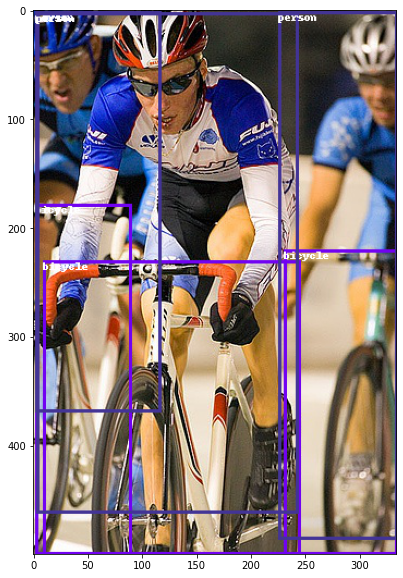

In [120]:
img, target = train_ds[2]

colors = np.random.randint(0, 255, size=(80,3), dtype='uint8')
def show(img, targets, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    W, H = img.size

    for tg in target:
        id_ = int(tg[0])
        bbox = tg[1:5]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))
plt.figure(figsize=(10,10))
show(img, target)

# 2. augmentation 적용하기

# 3. 모델 구축하기
- RetinaNet은 ResNet + FPN 구조를 갖습니다.
- ResNet을 구현할 때, PyTorch 공식 홈페이지 ResNet 모델과 변수 명이 같아야 pre-trained model을 불러올 수 있습니다.
- https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnext50_32x4d

In [180]:
# BottleNeck of ResNet
class Bottleneck(nn.Module):
    expand = 4

    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))

        return output

def test():
    x = torch.randn(1, 56,13,13)
    net = BottleNeck(x.size(1), x.size(1))
    output = net(x)
    print(output.size())

test()

torch.Size([1, 56, 13, 13])


In [184]:
# FPN
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # Bottom-up layers and ResNet
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6
        self.conv7 = nn.Sequential(                                  # p7
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)

        p5 = self.lateral_1(c5)
        p4 = self.top_down_1(self.upsample(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels*Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50():
    return FPN([3,4,6,3])

if __name__ == '__main__':
    x = torch.randn(3, 3, 224, 224)
    model = FPN50()
    outputs = model(x)
    for output in outputs:
        print(output.size())

torch.Size([3, 256, 28, 28])
torch.Size([3, 256, 14, 14])
torch.Size([3, 256, 7, 7])
torch.Size([3, 256, 4, 4])
torch.Size([3, 256, 2, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [144]:
# pritrained ResNet50 weights 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

--2021-04-13 16:37:06--  https://download.pytorch.org/models/resnet50-19c8e357.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.249.93.56, 13.249.93.46, 13.249.93.14, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.93.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102502400 (98M) [application/octet-stream]
Saving to: ‘resnet50-19c8e357.pth’

resnet50-19c8e357.p 100%[===================>]  97.75M  60.2MB/s    in 1.6s    

2021-04-13 16:37:08 (60.2 MB/s) - ‘resnet50-19c8e357.pth’ saved [102502400/102502400]



In [147]:

class RetinaNet(nn.Module):
    num_anchors = 9
    
    def __init__(self, num_classes=20):
        super(RetinaNet, self).__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4)
        self.cls_head = self._make_head(self.num_anchors*self.num_classes)

    def forward(self, x):
        fms = self.fpn(x)
        loc_preds = []
        cls_preds = []
        for fm in fms:
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)                 # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes)  # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_planes):
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.Conv2d(256, out_planes, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

In [153]:

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out


class FPN(nn.Module):
    def __init__(self, block, num_blocks):
        super(FPN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Bottom-up layers
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(2048, 256, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d( 256, 256, kernel_size=3, stride=2, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)

        # Top-down layers
        self.toplayer1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.toplayer2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        p6 = self.conv6(c5)
        p7 = self.conv7(F.relu(p6))
        # Top-down
        p5 = self.latlayer1(c5)
        p4 = self._upsample_add(p5, self.latlayer2(c4))
        p4 = self.toplayer1(p4)
        p3 = self._upsample_add(p4, self.latlayer3(c3))
        p3 = self.toplayer2(p3)
        return p3, p4, p5, p6, p7


def FPN50():
    return FPN(Bottleneck, [3,4,6,3])


In [165]:
print('Loading pretrained ResNet50 model..')
# d = torch.load('/content/resnet50-19c8e357.pth')
d == net.state_dict()

Loading pretrained ResNet50 model..


False

In [183]:
print('Loading pretrained ResNet50 model..')
d = torch.load('/content/resnet50-19c8e357.pth')
print('Loading into FPN50..')
fpn = FPN50()
dd = fpn.state_dict()
for k in d.keys():
    if not k.startswith('fc'):  # skip fc layers
        dd[k] = d[k]

print('Saving RetinaNet..')
net = RetinaNet()
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        init.normal(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant(net.cls_head[-1].bias, -math.log((1-pi)/pi))

net.fpn.load_state_dict(dd)
torch.save(net.state_dict(), 'net.pth')
print('Done!')

Loading pretrained ResNet50 model..
Loading into FPN50..
Saving RetinaNet..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Done!


In [163]:
print(net.state_dict())

OrderedDict([('fpn.conv_1.0.weight', tensor([[[[ 6.9703e-02, -7.8723e-03,  1.8068e-02,  ..., -1.7592e-02,
            7.6429e-02,  4.6992e-03],
          [-7.9302e-02, -5.4127e-03,  1.7447e-02,  ...,  5.9739e-02,
            2.3081e-02,  8.3631e-03],
          [ 1.5647e-02, -7.3953e-02, -3.4995e-02,  ..., -3.7778e-02,
           -1.4662e-02,  4.1064e-02],
          ...,
          [-4.1928e-02,  5.9837e-02, -6.8461e-03,  ..., -4.4087e-02,
            7.8560e-02, -6.0318e-02],
          [ 7.3538e-02,  7.7361e-02, -3.4803e-02,  ...,  7.7860e-02,
           -7.1993e-02,  6.0777e-02],
          [-4.9546e-02, -5.0917e-02, -5.7884e-03,  ..., -3.0174e-02,
            5.2794e-02,  4.1606e-02]],

         [[-1.3419e-03,  3.5915e-02, -1.0493e-02,  ..., -7.4302e-02,
           -7.3665e-02, -6.1548e-02],
          [ 5.6088e-02,  3.4562e-02,  7.1035e-02,  ..., -2.0933e-02,
           -3.8605e-02, -2.5998e-02],
          [ 4.4734e-02, -5.5393e-02, -4.4198e-02,  ...,  8.0365e-02,
           -1.7220e-0